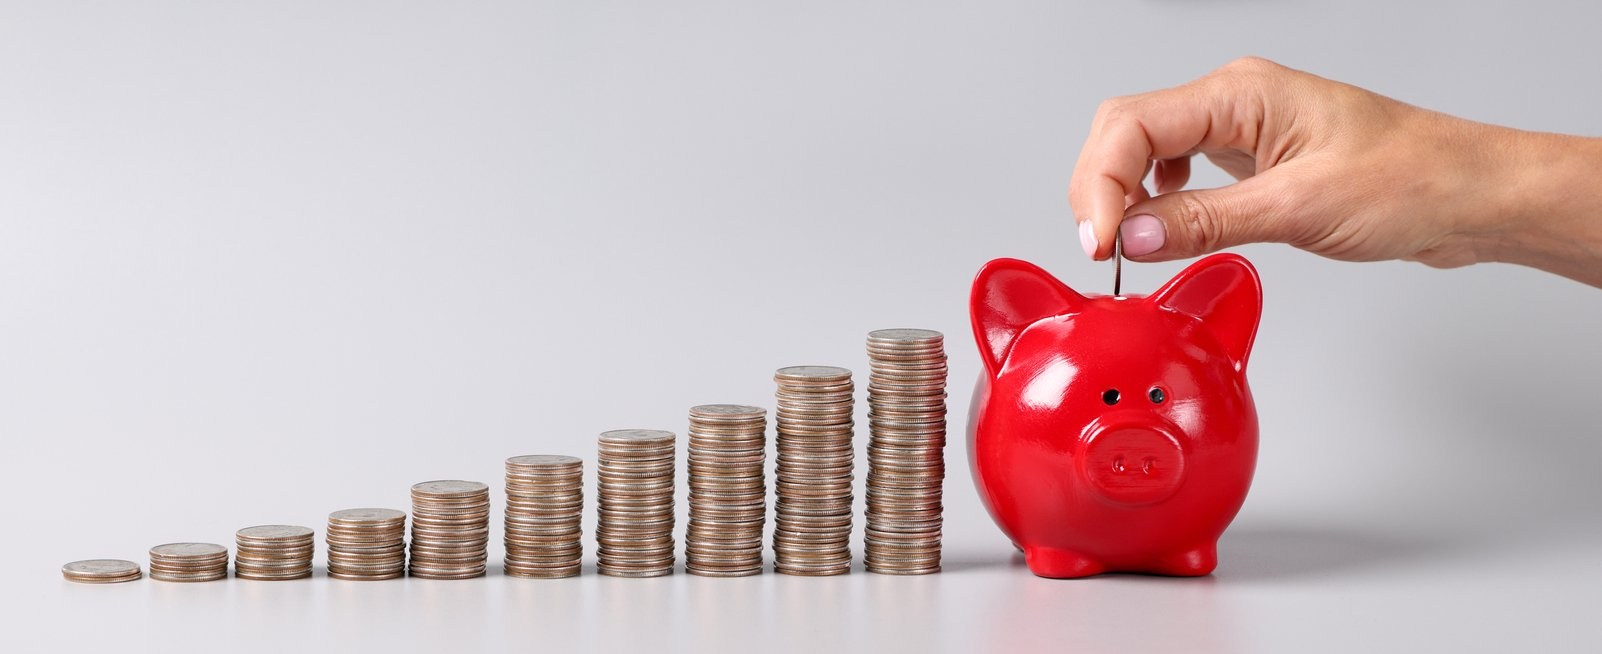

# Forecast of willingness to make a deposit

В данной работе нам предстоит решить задачу, которая часто встаёт перед аналитиками, работающими в банковском секторе.

**Введение**

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

**Задача**

Нам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Мы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если мы сможем это сделать, то поднимем доходы банка и поможем понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача для специалиста в Data Science**: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

<a id = '0'></a>
<p><strong>Содержание</strong></p> 

* <a href ="#1">Знакомство с данными и базовая модель</a>
  * <a href ="#1.1">Базовая модель</a>
* <a href ="#2">Анализ данных</a>
* <a href ="#3">Преобразование данных</a>
* <a href ="#4">Моделирование</a>
  * <a href ="#4.1">Логистическая регрессия и решающее дерево</a>
  * <a href ="#4.2">Ансамбли моделей</a>
  * <a href ="#4.3">Снова CatBoost</a>
* <a href ="#5">Результаты и выводы</a>


In [1]:
# Подгрузим библиотеки и прочие инструменты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier
%matplotlib inline
plt.style.use('seaborn-v0_8')
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

## Знакомство с данными и базовая модель

<a id='1'></a>
<a href ="#0">Вернуться к содержанию.</a>

Подгрузим данные и посмотрим на таблицу.

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Разберемся с признаками и опишем их.

#### <center> Данные о клиентах банка
|Признак|age|job|marital|education|default|housing|loan|balance|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|**Описание**|возраст|сфера занятости|семейное положение|уровень образования|наличие просроченного кредита|наличие кредита на жилье|наличие кредита на личные нужды|баланс|

#### <center> Данные связанные с последним контактом в контексте текущей маркетинговой кампании
|Признак|contact|month|day|duration|
|:-:|:-:|:-:|:-:|:-:|
|**Описание**|тип контакта с клиентом|месяц, в котором был последний контакт|день, в который был последний контакт|продолжительность контакта в секундах|
    
#### <center> Прочие признаки
|Признак|campaign|pdays|previous|poutcome|
|:-:|:-:|:-:|:-:|:-:|
|**Описание**|количество контактов с этим клиентом в течение текущей кампании|количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании|количество контактов до текущей кампании|результат прошлой маркетинговой кампании|
    
И, разумеется, наша **целевая переменная** *deposit*, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы и будем пытаться предсказать в данной работе.

In [3]:
# Распечатаем краткое описание данных
df.info()
print(f'\nКоличество пропусков в признаке balance: {sum(df.balance.isnull())}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB

Количество пропусков в признаке balance: 25


Тип данных в этом столбце object, оформим список из нескольких первых значений, чтобы лучше определить символьный состав строк.

In [4]:
list(df.balance[:9])

[' 2 343,00 $ ',
 ' 45,00 $ ',
 ' 1 270,00 $ ',
 ' 2 476,00 $ ',
 ' 184,00 $ ',
 '0  $ ',
 ' 830,00 $ ',
 ' 545,00 $ ',
 ' 1,00 $ ']

Как видим, предстоит избавиться от пробелов и знака доллара, а также заменить запятую на точку. В качестве проверки корректности замен выведем средний баланс клиентов.

In [5]:
df.balance = df.balance.str.replace(',', '.')
df.balance = df.balance.str.replace('$', '')
df.balance = df.balance.str.replace(' ', '')
df.balance = df.balance.astype(float)
print(f'Средний баланс клиентов: {round(df.balance.mean(), 2)}')

Средний баланс клиентов: 1529.13


Теперь избавимся от пропусков. Их не так уж и много (25), заменим их на медианные значения по данному признаку.

In [6]:
df.loc[df.balance.isnull(), 'balance'] = df.balance.median()
print(f'Средний баланс клиентов: {round(df.balance.mean(), 2)}')

Средний баланс клиентов: 1526.94


### Базовая модель
<a id='1.1'></a>
<a href ="#0">Вернуться к содержанию.</a>

balance был единственным некатегориальным признаком, отображаемым в текстовой форме. Мы это исправили и теперь можем отправить данные в нашу базовую модель, в качестве которой не мудрствуя лукаво изберем CatBoostClassifier. Он отлично подходит для ленивого моделирования, т.к. не нуждается в перекодировке данных и не страшится пропусков.

In [7]:
%%time
# Отделим таргет от фич
X_bl = df.drop(['deposit'], axis=1)
y_bl = df['deposit']
# А таргет мы все же перекодируем
y_bl = y_bl.apply(lambda x: 1 if x == 'yes' else 0)
# Перечислим в списке категориальные признаки
cat_features = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'poutcome'
]
# Разделим датасет на трейн и тест
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(
    X_bl, y_bl, stratify=y_bl, random_state = 42, test_size = 0.3)
# Объявим модель
bl_cbc = CatBoostClassifier(
    random_state=42,
    verbose=False,
    cat_features=cat_features
)
# Обучаем
bl_cbc.fit(X_train_bl, y_train_bl)
# Предсказываем
y_pred_bl_cbc = bl_cbc.predict(X_test_bl)
# Выведем метрики
print(f'bl_cbc accuracy-score: {round(metrics.accuracy_score(y_test_bl, y_pred_bl_cbc), 4)}')
print(f'bl_cbc f1-score: {round(metrics.f1_score(y_test_bl, y_pred_bl_cbc), 4)}')
pred_proba_bl_cbc = bl_cbc.predict_proba(X_test_bl)[:, 1]
roc_auc_bl_cbc = metrics.roc_auc_score(y_test_bl, pred_proba_bl_cbc).round(4)
print("roc-auc на тестовой выборке:", roc_auc_bl_cbc)

bl_cbc accuracy-score: 0.8638
bl_cbc f1-score: 0.86
roc-auc на тестовой выборке: 0.9333
CPU times: total: 1min 6s
Wall time: 17.1 s


Довольно неплохие результаты уже с дефолтными параметрами модели. Вряд ли мы сможем сделать что-то лучшее используя простые ml-алгоритмы, но нам необходимо с чем-то сравнивать, поэтому не станем здесь останавливаться.

## Анализ данных

<a id='2'></a>

<a href ="#0">Вернуться к содержанию.</a>

Для начала изучим распределение целевой переменной - есть ли несбалансированность классов. Чтобы это определить, вычислим частоты для открывших депозит и для тех, кто его не открыл. Сопроводим числа диаграммой, отражающей полученные результаты.

no deposit: 5873
yes deposit: 5289


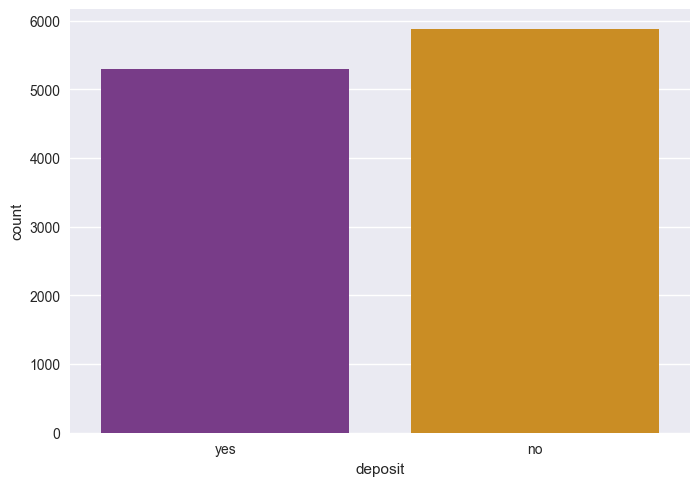

In [8]:
# Выведем числа и построим графику
sns.countplot(x='deposit', data=df, palette='CMRmap')
class_percent = df['deposit'].value_counts()
print('no deposit: {}'.format(class_percent[0]))
print('yes deposit: {}'.format(class_percent[1]))

Некоторый дисбаланс классов все же имеется.

Выведем описательные статистики для количественных переменных и визуализируем их распределения.

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1526.936033,3224.829691,-6847.0,123.0,550.0,1699.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


<Figure size 800x550 with 0 Axes>

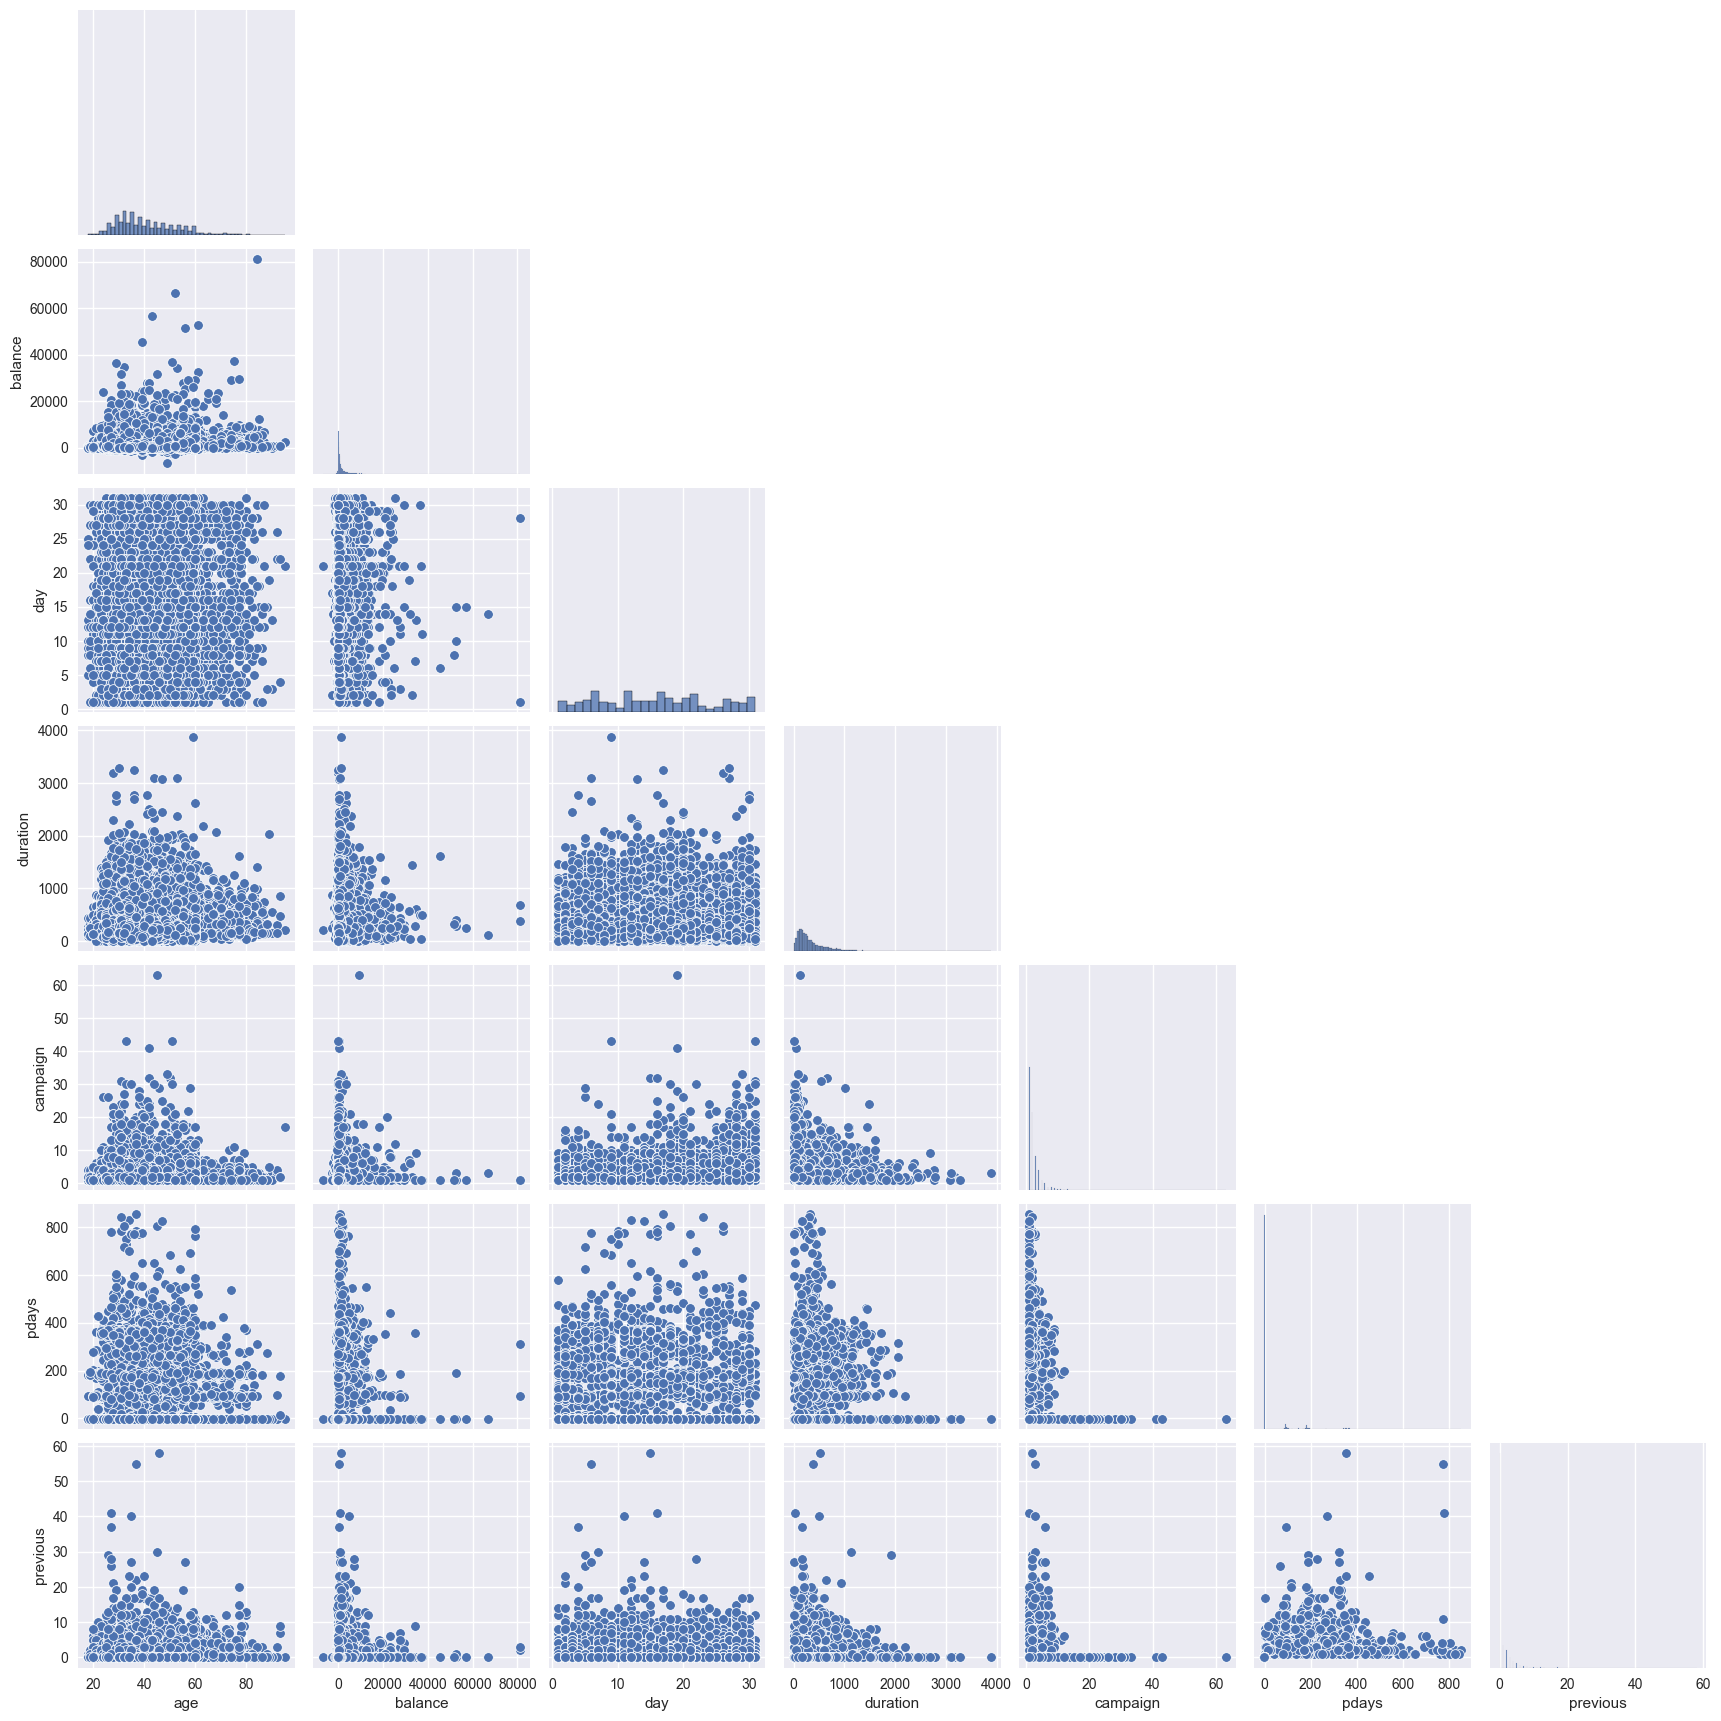

In [9]:
# Таблица описательных статистик
display(df.describe().T)
# Распределения
to_plot = [
    'age', 'balance', 'day', 'duration',
    'campaign', 'pdays', 'previous'
]
plt.figure()
sns.pairplot(df[to_plot], corner=True)
plt.show()


Возраст распределен сравнительно нормально, с пиком в районе 30 лет.<br>
В распределении значений балансов клиентов явно есть выбросы. Еще четыре признака имею широкие хвосты: duration, campaign, pdays, previous. Значит при нормализации данных следует использовать в качестве скейлера RobustScaler, который проводит нормализацию по межквартильному размаху.<br>
Любопытное наблюдение: клиенты старше 60 почти не имеют отрицательных балансов.

Теперь рассмотрим описательные статистики для категориальных переменных.

In [10]:
# Описательные статистики для категориальных переменных
display(df.describe(include='object'))

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,5881,9702,8042,2824,8326,5873


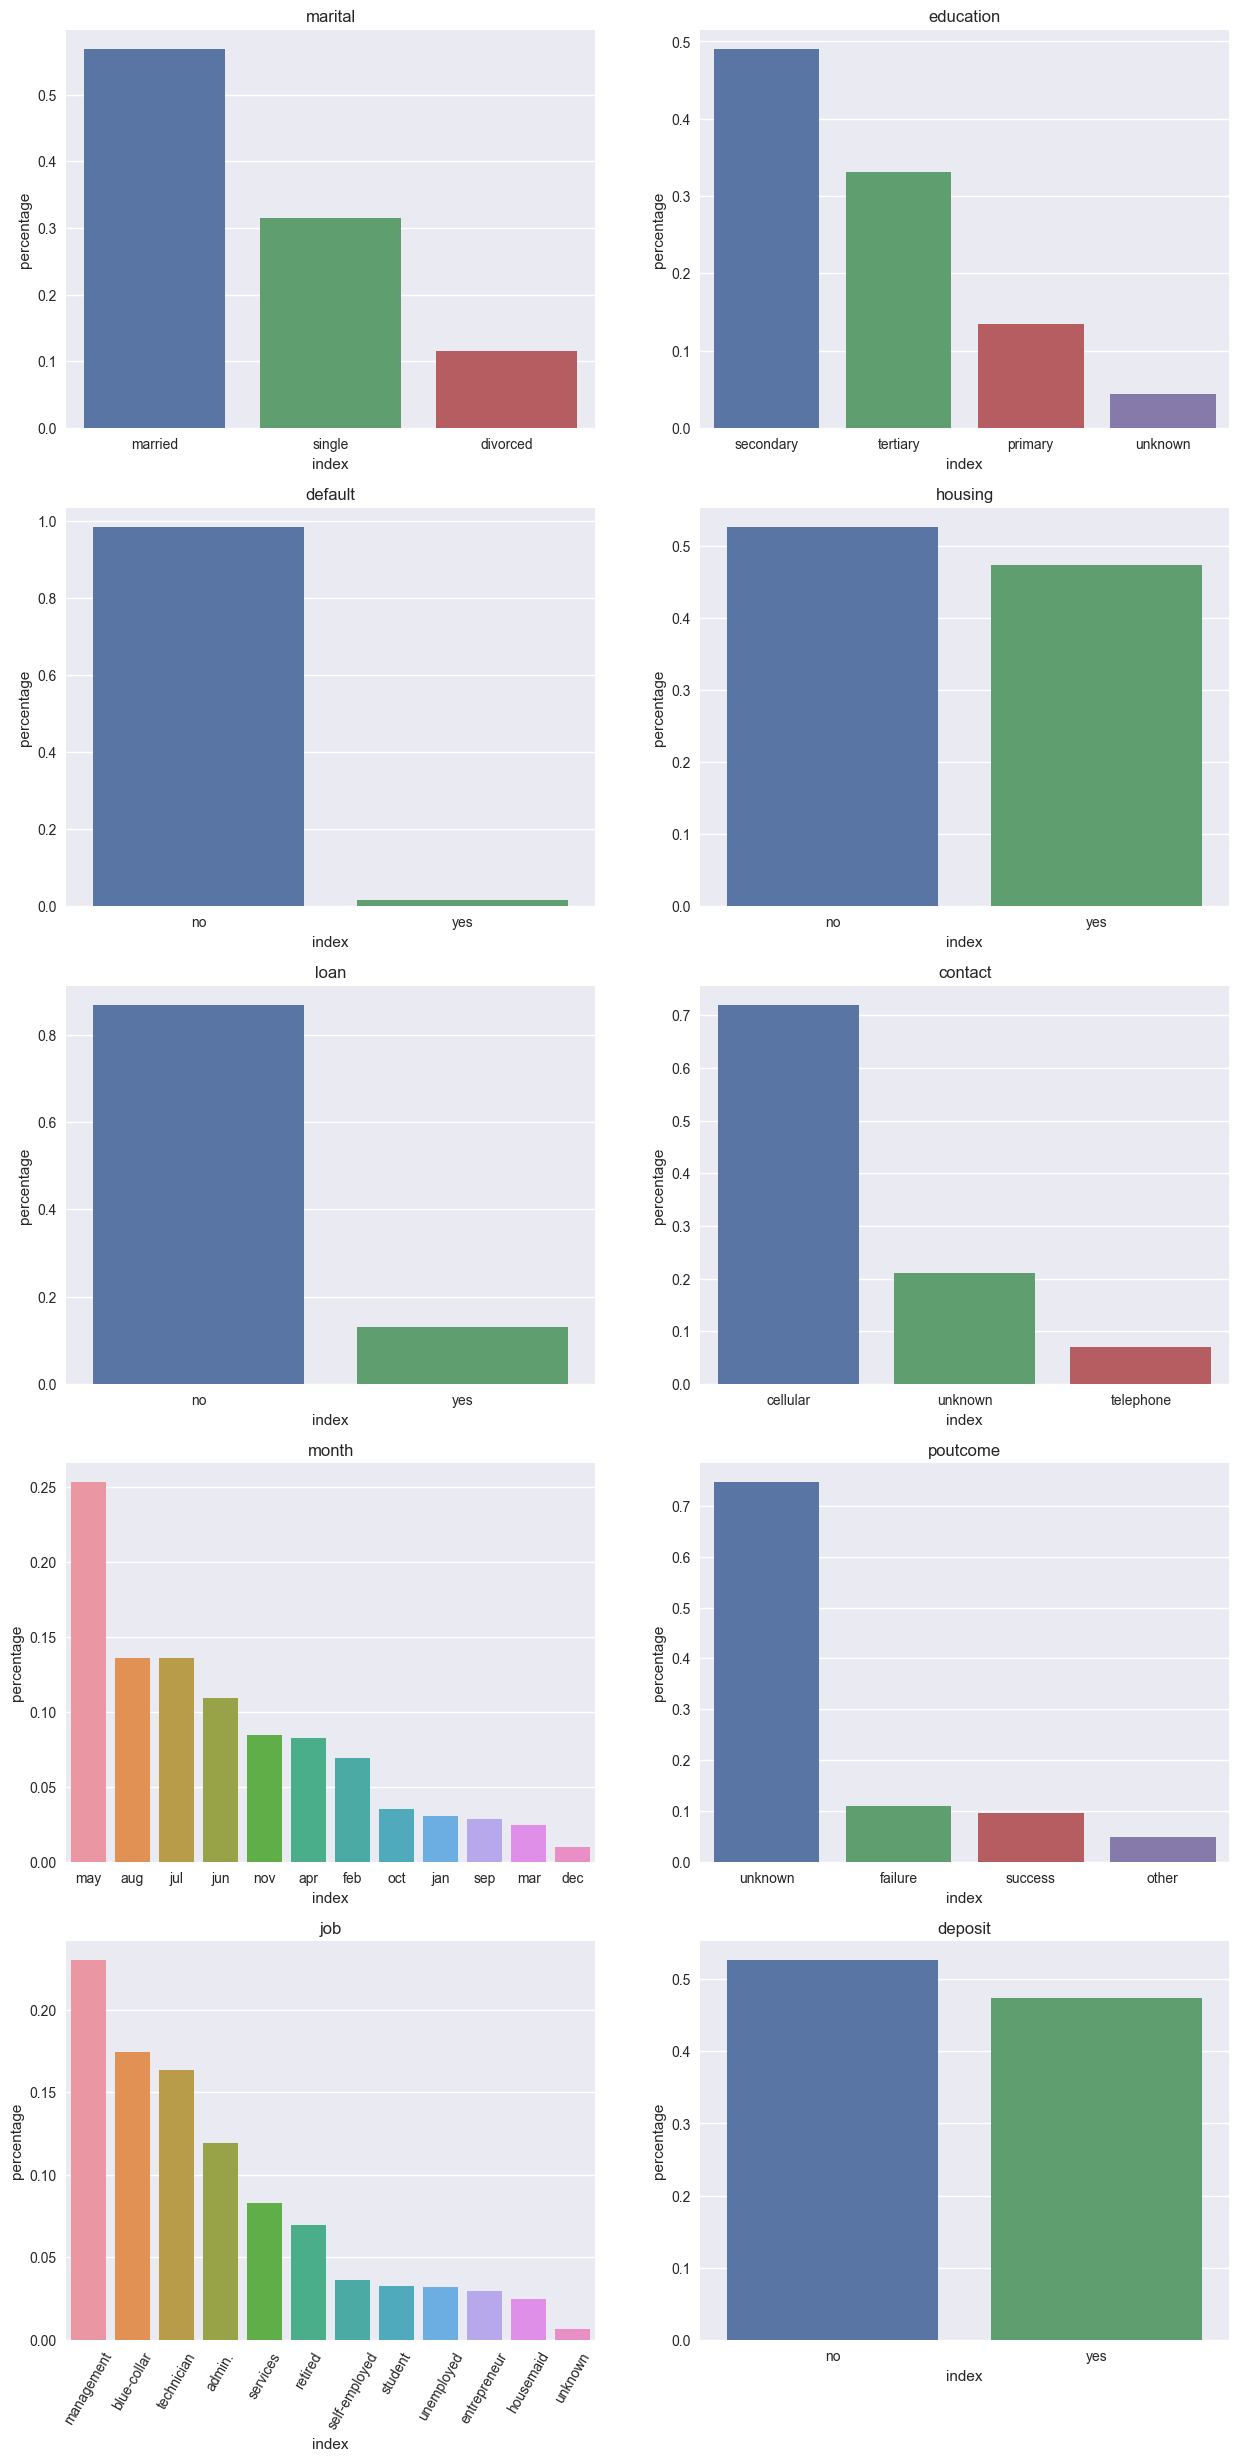

In [11]:
# Составим список признаков
features = [
    'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'poutcome', 'job', 'deposit'
]
fig, axes = plt.subplots(5, 2, figsize=(15, 30))

# Создаём цикл для всех признаков из списка категориальных признаков
j = 0
for i, feature in enumerate(features):
    # Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных.
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[j][i%2])
    count_barplot.set_title(feature)
    if feature == 'job':
        count_barplot.xaxis.set_tick_params(rotation=60)
    if i % 2:
        j += 1

Среди клиентов банка наибольшее представление имеют специалисты из сферы менеджмента. Следом идут т.н. синие воротнички (blue-collar): представители рабочих профессий. Затем технические специалисты, а четвертыми, видимо, работники сферы администрирования.

Помимо явно определенных сфер (их всего 11) в столбце признака также имеются 'unknown'-значения. Такие данные можно было бы и удалить, т.к. оставить их нельзя и мы потеряли бы всего лишь 70 строк, но мы попробуем предсказать их "реальные" значения, воспользовавшись тем же алгоритмом CatBoost. То же самое мы провернем c 'unknown'-значениями признака education.

Касательно образования, как видим, клиенты чаще всего имеют среднее либо высшее. По семейному положению больше представлен класс женатых.

Огромный дисбаланс классов наблюдается в признаках default и loan - их значения, скорее всего, окажут слабое влияние на предсказательную силу моделей.

Больше всего усилий по привлечению новых вкладчиков было приложено в мае.

А по результатам прошлой маркетинговой кампании видим подавляющую долю неизвестных. Чаще всего контакт с клиентами осуществлялся по мобильному телефону.

In [12]:
# Посмотрим, для какого статуса предыдущей маркетинговой кампании
# успех в текущей превалирует над количеством неудач
df.groupby(['poutcome'])['deposit'].value_counts(1).to_frame()

deposit
poutcome deposit          
failure  yes      0.503257
         no       0.496743
other    yes      0.571695
         no       0.428305
success  yes      0.913165
         no       0.086835
unknown  no       0.593322
         yes      0.406678

In [13]:
# Посмотрим, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby(['month'])['deposit'].value_counts(1).to_frame().T

month         apr                aug                dec                 feb  \
deposit       yes        no       no      yes       yes        no       yes   
deposit  0.625135  0.374865  0.54707  0.45293  0.909091  0.090909  0.568299   

month                   jan                 jul                 jun            \
deposit        no        no       yes        no       yes        no       yes   
deposit  0.431701  0.587209  0.412791  0.585865  0.414135  0.553191  0.446809   

month         mar                may                nov                oct  \
deposit       yes        no       no      yes        no       yes      yes   
deposit  0.898551  0.101449  0.67245  0.32755  0.572641  0.427359  0.82398   

month                 sep           
deposit       no      yes       no  
deposit  0.17602  0.84326  0.15674

И этот месяц - май. Как помним по графикам, именно в этот месяц сотрудники банка чаще всего докучали клиентам.

Хотелось бы также посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создадим новую переменную, в которой и будет находиться индикатор принадлежности к одной из следующих категорий:
 * '<30';
 * '30-40';
 * '40-50';
 * '50-60';
 * '60+'.

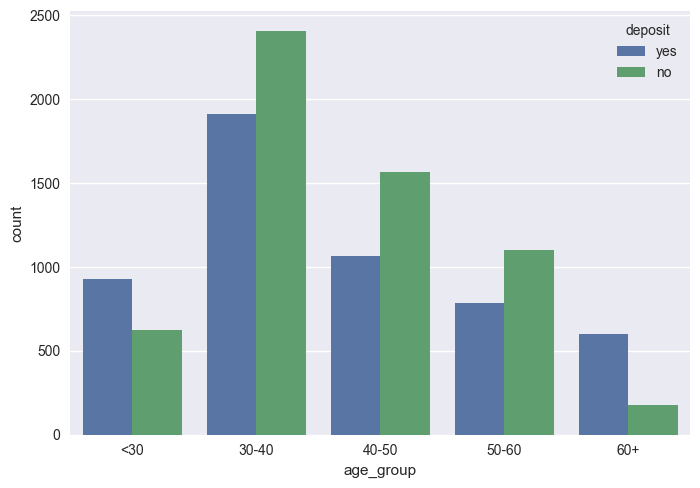

In [14]:
# Создадим новую переменную
df['age_group'] = pd.cut(
    df['age'],
    bins=[0, 29, 39, 49, 59, 100],
    labels=['<30', '30-40', '40-50', '50-60', '60+']
)
# Отрисуем графику
sns.countplot(data=df, x='age_group', hue='deposit');

Чаще всего депозиты открывают клиенты из категории 30-40 лет, но лишь в возрастных группах "до 30" и "60+" более склонны открывать депозит после маркетинговой кампании.

Теперь посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:
 * семейное положение;
 * уровень образования;
 * сфера занятости.

Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий вышеназванных признаков.

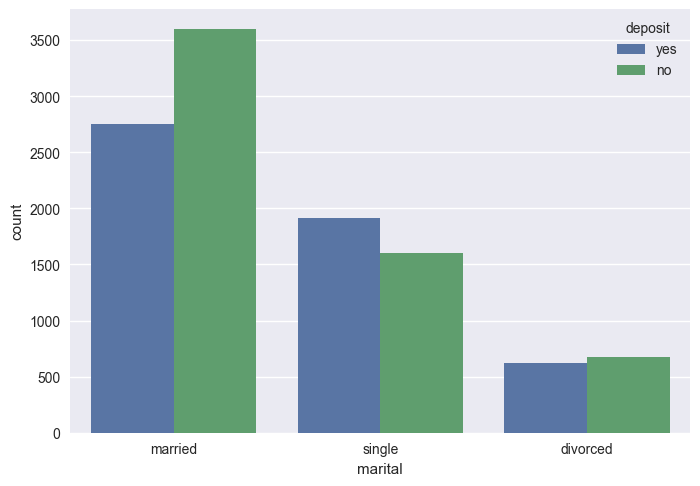

In [15]:
# Построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(data=df, x='marital', hue='deposit');

Больше всего депозитов открывали женатые, но одиночки соглашались чаще, чем отказывали.

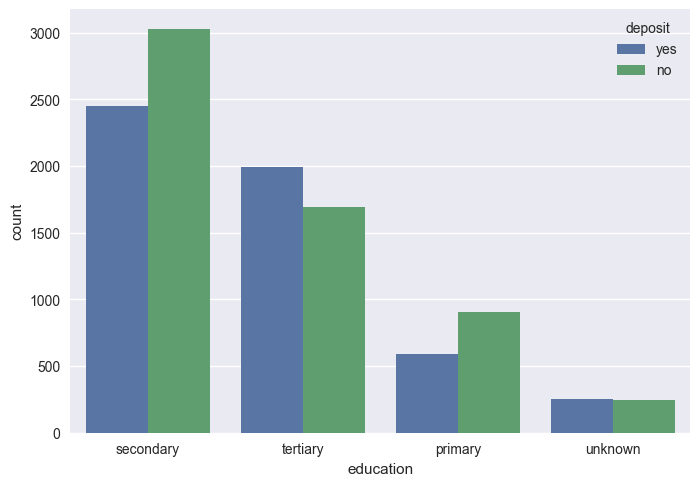

In [16]:
# Построим визуализацию для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(data=df, x='education', hue='deposit');

Клиенты с высшим образованием чаще соглашались открыть депозит, чем отказывали. Столбик согласившихся у категории неизвестных тоже несколько выше столбика отказавшихся, но с ними мы разберемся чуть позже.

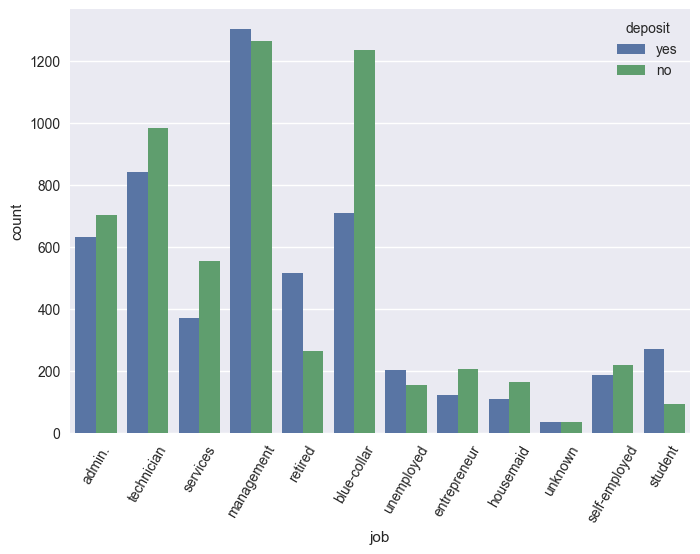

In [17]:
# Построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
cntplt = sns.countplot(data=df, x='job', hue='deposit')
cntplt.xaxis.set_tick_params(rotation=60);

Чаще всего соглашались, чем отказывали: клиенты, работающие в сфере менеджмента, а также пенсионеры, безработные (?!) и студенты.

Посмотрим теперь на пересечения категорий. Построим сводную диаграмму по уровню образования и семейному положению - сперва для согласившихся открыть депозит, затем для откзавших.

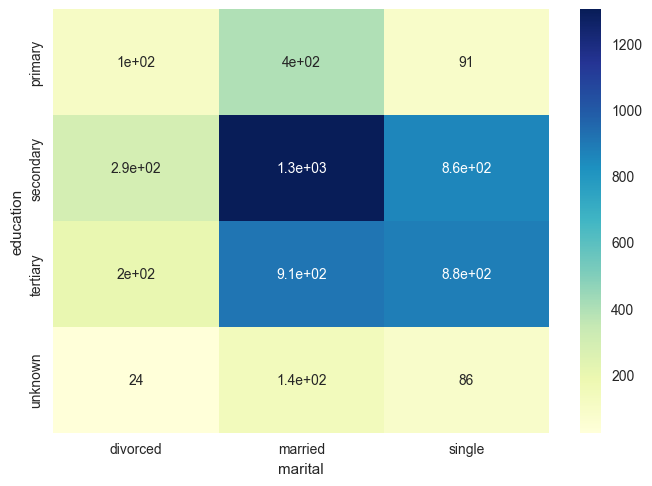

In [18]:
# Построим сводную таблицу по согласившимся
pivot1 = df[df['deposit'] == 'yes'].pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)
# Визуализируем ее в виде тепловой карты
sns.heatmap(data=pivot1, cmap='YlGnBu', annot=True);

Чаще всего соглашались открыть депозит женатые со средним образованием. Затем идут женатые и одиночки с высшим образованием. Далее одиночки со средним образованием. Реже всего соглашались (если мы игнорируем категорию с неизвестным уровнем образования) одиночки с начальным образованием.

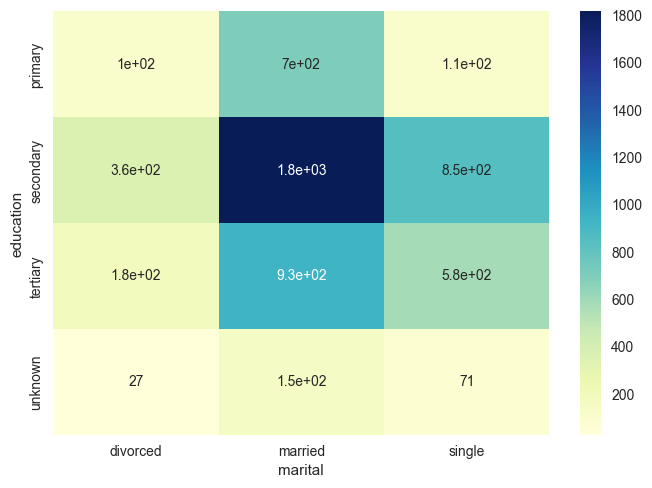

In [19]:
# Построим сводную таблицу по отказавшим
pivot2 = df[df['deposit'] == 'no'].pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)
# Визуализируем ее в виде тепловой карты
sns.heatmap(data=pivot2, cmap='YlGnBu', annot=True);

Чаще всего отказывали также женатые со средним образованием. Затем также женатые с высшим образованием. Но следом уже одиночки со вредним образованием. Реже всех отказывали (также без учета категории с неизвестным уровнем образования) разведенные с начальным образованием - впрочем, их оказалось столько же, сколько и согласившихся в той же категории.

Теперь посмотрим на зависимость баланса клиента от занятости.

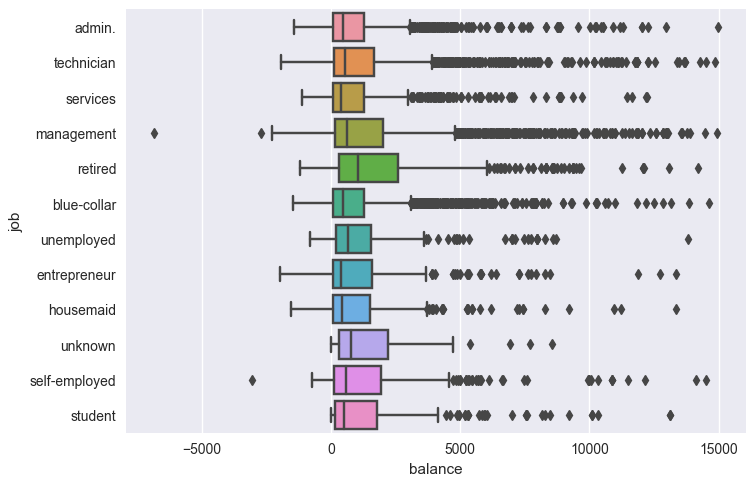

In [20]:
# Коробчатые диаграммы распределений балансов на счетах в зависимости от занятости клиентов
sns.boxplot(data=df, x=df[df['balance'] < 15000]['balance'], y=df['job']);

Из-за огромной дисперсии балансов мы применили маску, чтобы получше рассмотреть положение межквартильных размахов и линий медианн. Однако даже так большую часть картинки занимают ромбики выбросов. Но даже так нетрудно заметить, что лучше всего дела с балансом на счетах обстоят у пенсионеров. Распределение балансов среди менеджеров выглядит куда интереснее: модуль отрицательных балансов выше всего у них, да и выбросов в отрицательную сторону у них целых два: возможно клиенты из сферы менеджмента просто ведут более активную финансовую жизнь. Только клиенты из категорий студенты и неизвестные вовсе не имеют долгов.

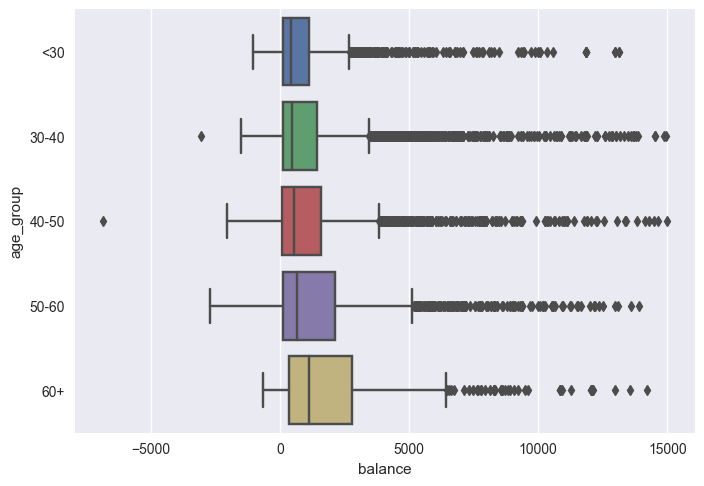

In [21]:
# Коробчатые диаграммы распределений балансов на счетах в зависимости от возростной группы
sns.boxplot(data=df, x=df[df['balance'] < 15000]['balance'], y=df['age_group']);

А здесь мы можем видить тенденцию к накоплению сбережений.

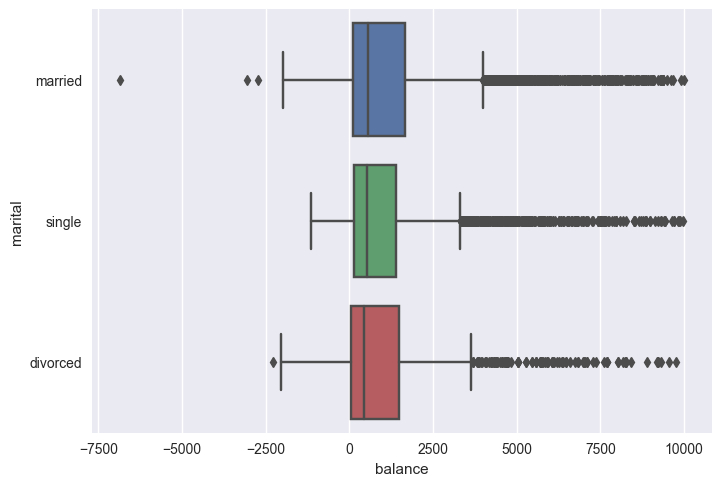

In [22]:
# Коробчатые диаграммы распределений балансов на счетах в зависимости от семейного положения
sns.boxplot(data=df, x=df[df['balance'] < 10000]['balance'], y=df['marital']);

Долгов у одиночек меньше, чем у двух других групп. Но со средствами на счетах у женатых все же дела получше, чем у остальных.

## Преобразование данных

<a id='3'></a>

<a href ="#0">Вернуться к содержанию.</a>

Настало время избавиться от unknown в признаках job и education. Мы, как уже писали выше, не просто заменим эти значения модами, но попытаемся предсказать наиболее вероятные категории на их месте. Для этого мы воспользуемся алгоритмом CatBoostClassifier, который способен решать задачи мультиклассификации: в обоих дополняемых признаках классов более чем 2.

In [23]:
# Взглянем на категории занятости
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [24]:
%%time
# Объявляем матрицу признаков
x_job = df.drop(columns=['job', 'education'])
# Создаем словарь для кодирования классов
yj_encoder_dict = {
    'management':0, 'blue-collar':1, 'technician':2, 'admin.':3,
    'services':4, 'retired':5, 'self-employed':6, 'student':7, 
    'unemployed':8, 'entrepreneur':9, 'housemaid':10
}
# Проводим кодировку таргета
y_job = df['job'].apply(
    lambda x: yj_encoder_dict[x] if x in yj_encoder_dict else x
)
# Формируем выборки
y_job_train = y_job[y_job.values != 'unknown']
y_job_test = y_job[y_job.values == 'unknown']
x_job_train = x_job.iloc[y_job_train.index]
x_job_test = x_job.iloc[y_job_test.index]
# Формируем список категориальных признаков
cat_features = [
    'marital', 'default', 'housing', 'loan', 'contact',
    'month', 'poutcome', 'deposit', 'age_group'
]
# Объявляем модель
cbc_model_for_job_fillna = CatBoostClassifier(
    random_state=42,
    verbose=False,
    cat_features=cat_features
)
# Проводим его обучение на трейне
cbc_model_for_job_fillna.fit(x_job_train, y_job_train)
# Предсказываем классы занятости
y_pred_job_test = cbc_model_for_job_fillna.predict(x_job_test)
# Создаем словарь для декодировки классов
yj_decoder_dict = {}
for k, v in yj_encoder_dict.items():
    yj_decoder_dict[v] = k
# Заменяем поиндексно unknown-значения на предсказанные в исходном датасете
for i, ni in enumerate(x_job_test.index):
    df.loc[ni, 'job'] = int(y_pred_job_test[i])
# И уже в столбце признака декодируем классы
df['job'] = df['job'].apply(
    lambda x: yj_decoder_dict[x] if x in yj_decoder_dict else x
)

CPU times: total: 15min 52s
Wall time: 1min 36s


In [25]:
# Взглянем на результат
df.job.value_counts()

management       2608
blue-collar      1951
technician       1829
admin.           1336
services          923
retired           789
self-employed     405
student           361
unemployed        357
entrepreneur      328
housemaid         275
Name: job, dtype: int64

Мы успешно избавились от класса неизвестных в признаке.

Теперь проделаем то же самое с признаком education.

In [26]:
# Взглянем на категории образования
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [27]:
%%time
# Объявляем матрицу признаков
x_edu = df.drop(columns='education')
# Создаем словарь для кодирования классов
ye_encoder_dict = {'primary':0, 'secondary':1, 'tertiary':2}
# Проводим кодировку таргета
y_edu = df['education'].apply(
    lambda x: ye_encoder_dict[x] if x in ye_encoder_dict else x
)
# Формируем выборки
y_edu_train = y_edu[y_edu.values != 'unknown']
y_edu_test = y_edu[y_edu.values == 'unknown']
x_edu_train = x_edu.iloc[y_edu_train.index]
x_edu_test = x_edu.iloc[y_edu_test.index]
# Формируем список категориальных признаков
cat_features = [
    'job', 'marital', 'default', 'housing', 'loan',
    'contact', 'month', 'poutcome', 'deposit', 'age_group'
]
# Объявляем модель
cbc_model_for_edu_fillna = CatBoostClassifier(
    random_state=42,
    verbose=False,
    cat_features=cat_features
)
# Проводим его обучение на трейне
cbc_model_for_edu_fillna.fit(x_edu_train, y_edu_train)
# Предсказываем классы занятости
y_pred_edu_test = cbc_model_for_edu_fillna.predict(x_edu_test)
# Создаем словарь для декодировки классов
ye_decoder_dict = {}
for k, v in ye_encoder_dict.items():
    ye_decoder_dict[v] = k
# Заменяем поиндексно unknown-значения на предсказанные в исходном датасете
for i, ni in enumerate(x_edu_test.index):
    df.loc[ni, 'education'] = int(y_pred_edu_test[i])
# И уже в столбце признака декодируем классы
df['education'] = df['education'].apply(
    lambda x: ye_decoder_dict[x] if x in ye_decoder_dict else x
)

CPU times: total: 1min 59s
Wall time: 22.9 s


In [28]:
# Взглянем на результат
df.education.value_counts()

secondary    5764
tertiary     3830
primary      1568
Name: education, dtype: int64

Нам снова удалось избавиться от класса неизвестных.

 А теперь перекодируем все значения признака уже в датасете. Мы могли бы использовать для этого LabelEncoder, однако для данного порядкового категориального признака он неприемлем, т.к. его сортировка лейблов по алфавиту перед кодировкой сбивает естественный порядок классов.

In [29]:
# преобразуйте уровни образования
df['education'] = df['education'].apply(
    lambda x: ye_encoder_dict[x] if x in ye_encoder_dict else x
)

Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу.

Также перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [30]:
# Напишем словарь для кодировки
ag_encoder_dict = {'<30':0, '30-40':1, '40-50':2, '50-60':3, '60+':4}
# Заменим значения признака по словарю
df['age_group'] = df['age_group'].apply(lambda x: ag_encoder_dict[x])
# Перекодируем deposit
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

Сделаем то же самое для других бинарных переменных, которых у нас осталось три:
 * 'default';
 * 'housing';
 * 'loan'.

In [31]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:
 * 'job';
 * 'marital';
 * 'contact';
 * 'month';
 * 'poutcome'.

Создадим для них dummy-переменные и добавим их в набор данных.

In [32]:
# Создайте дамми-переменные
df_new = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
# Выведем размерность получившейся таблицы
df_new.shape

(11162, 46)

Теперь оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Построим также столбчатую диаграмму для ранжированных коэффициентов корреляции.

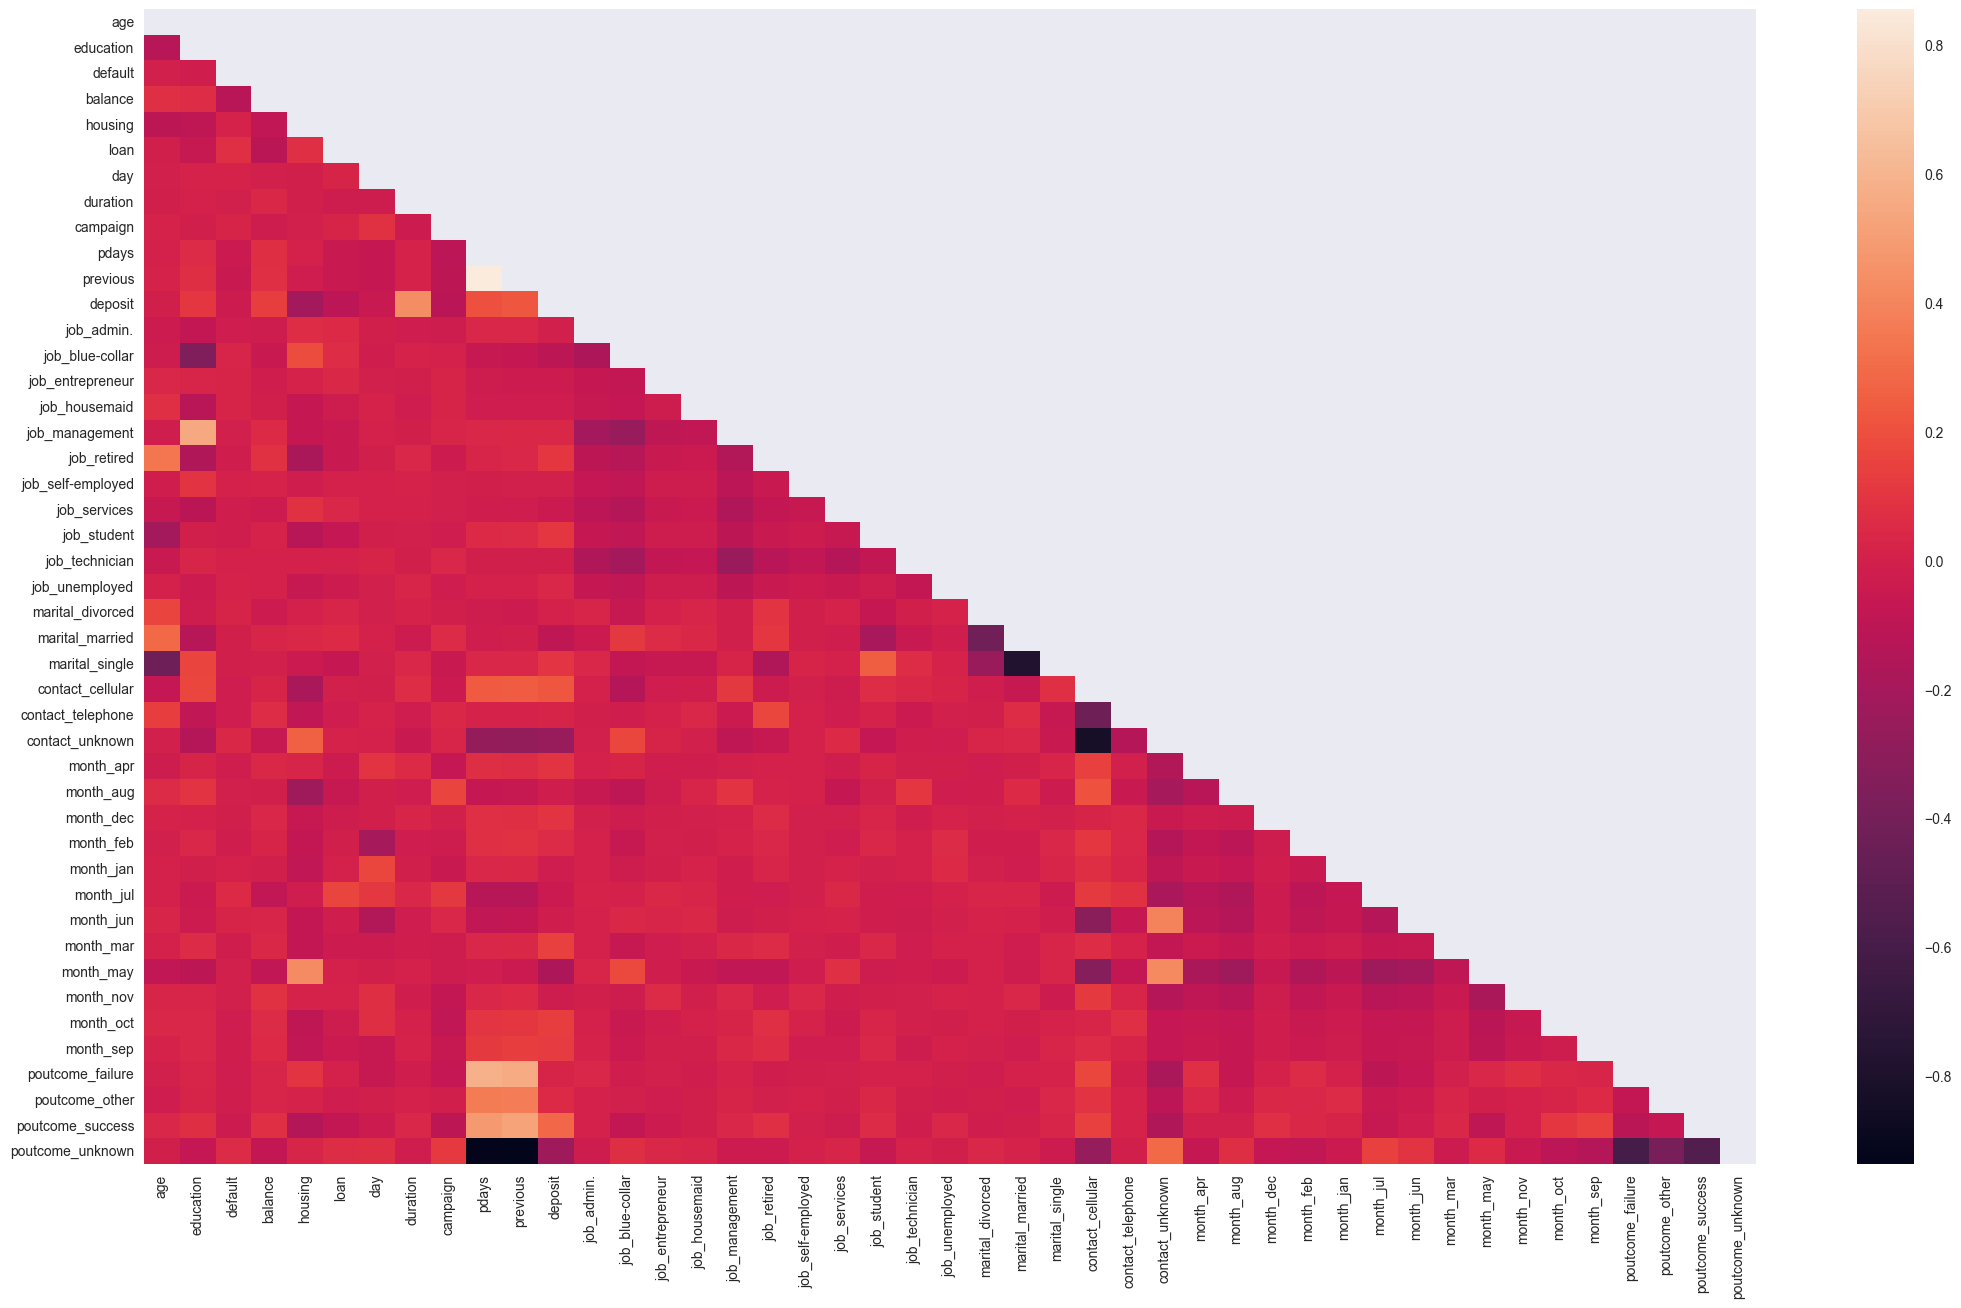

In [33]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

df_new_corr = df_new.corr(method='kendall')
# Выведем тепловую карту на основе матрицы корреляций
matrix = np.triu(df_new_corr)
fig, axes = plt.subplots(figsize=(26, 15))
sns.heatmap(df_new_corr, mask=matrix, ax=axes);

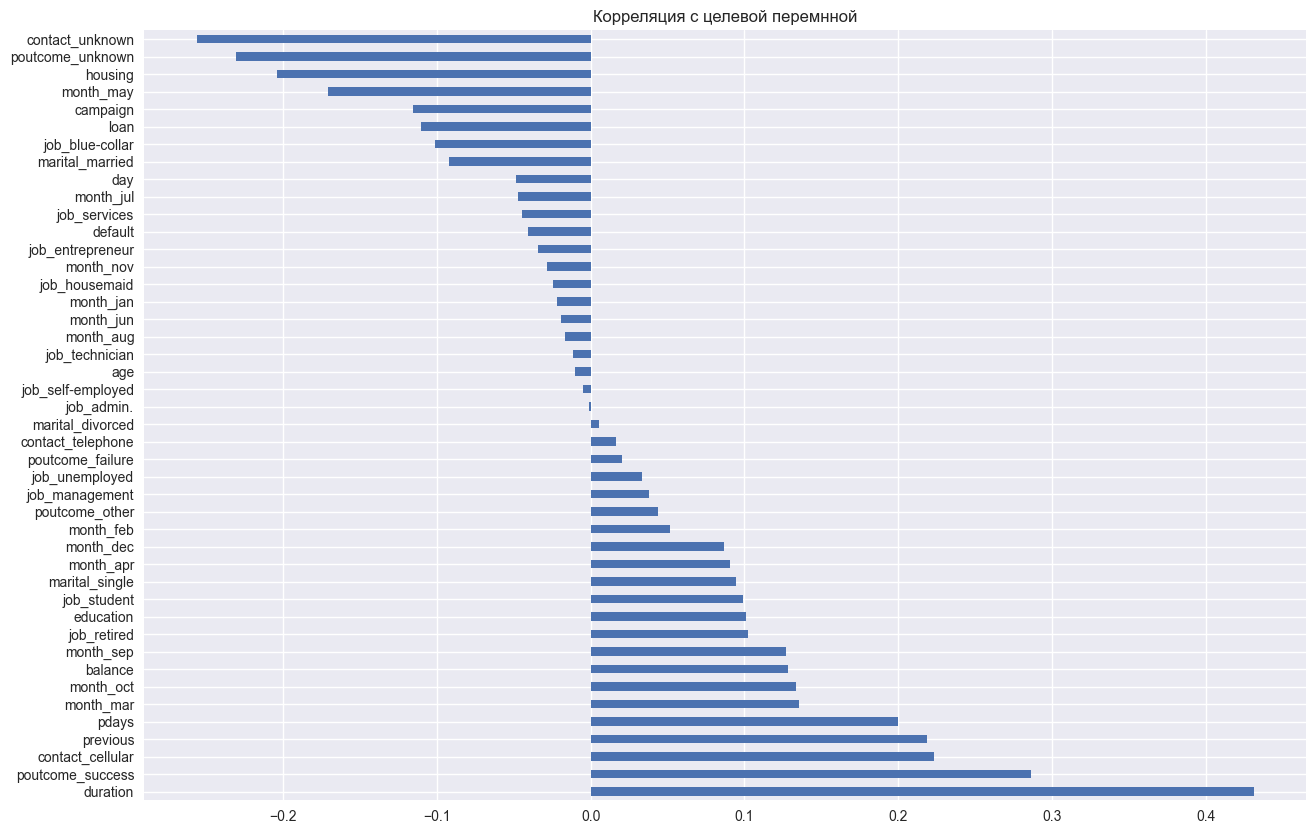

In [34]:
deposit_corrs = pd.Series(df_new_corr.deposit, index=df_new_corr.index).sort_values(ascending=0)
fig, ax = plt.subplots(figsize=(15, 10))
deposit_corrs[1:].plot(kind = 'barh', title='Корреляция с целевой перемнной');

Теперь определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.

In [35]:
X = df_new.drop(['deposit'], axis=1)
y = df_new['deposit']
# Сформируем выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.3
)
# Выведем размерность матриц
X_train.shape, X_test.shape

((7813, 45), (3349, 45))

Нормализуем предикторы в обучающей и тестовой выборках. Воспользуемся для этого Robust скейлером, как и планировали ранее.

In [36]:
r_scaler = preprocessing.RobustScaler()
r_scaler.fit(X_train)
X_train_scaled = r_scaler.transform(X_train)
X_test_scaled = r_scaler.transform(X_test)

## Моделирование

<a id='4'></a>

<a href ="#0">Вернуться к содержанию.</a>

### Логистическая регрессия и решающее дерево
<a id='4.1'></a>

Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag' и запустим 1000 итераций.

In [37]:
%%time
# Объявим модель
log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000
)
# Обучаем и предсказываем класс
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
# Выведем метрики
print(f'log_reg accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_lr), 4)}')
print(f'log_reg f1-score: {round(metrics.f1_score(y_test, y_pred_lr), 4)}')
pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
roc_auc_log_reg = metrics.roc_auc_score(y_test, pred_proba_log_reg).round(4)
print("roc-auc на тестовой выборке:", roc_auc_log_reg)


log_reg accuracy-score: 0.8262
log_reg f1-score: 0.8125
roc-auc на тестовой выборке: 0.9056
CPU times: total: 969 ms
Wall time: 962 ms


Результат, ожидаемо, похуже, чем у <a href ="#1.1">базовой модели</a>.

Простой алгоритм обучен. Теперь обучим решающее дерево. В качестве критерия информативности возьмем 'entropy'.

Переберем различные максимальные глубины деревьев и найдем такую, что даст максимальное значение метрики accuracy без наблюдаемого переобучения (т.е. должна сохраняться скорость роста accuracy на трейне и тесте: если первый начнет расти быстрее, то это будет значить, что модель уже склонна переобучаться).

In [38]:
%%time
# обучите решающие деревья, настройте максимальную глубину
dtc = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=7
)
# Обучаем
dtc.fit(X_train_scaled, y_train)
# Предсказываем класс на трейне
y_pred_train_dtc = dtc.predict(X_train_scaled)
# Выводим accuracy для трейна
print(f'dtc train accuracy-score: {round(metrics.accuracy_score(y_train, y_pred_train_dtc), 4)}')
# Предсказываем класс на тесте
y_pred_test_dtc = dtc.predict(X_test_scaled)
# Выводим метрики
print(f'dtc test accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_test_dtc), 4)}')
print(f'dtc f1-score: {round(metrics.f1_score(y_test, y_pred_test_dtc), 4)}')
pred_proba_dtc = log_reg.predict_proba(X_test_scaled)[:, 1]
roc_auc_dtc = metrics.roc_auc_score(y_test, pred_proba_dtc).round(4)
print("roc-auc на тестовой выборке:", roc_auc_dtc)

dtc train accuracy-score: 0.8232
dtc test accuracy-score: 0.817
dtc f1-score: 0.803
roc-auc на тестовой выборке: 0.9056
CPU times: total: 31.2 ms
Wall time: 30.1 ms


Теперь результат даже похуже, чем у логистической регрессии. Однако дерево решений поддается оптимизации. Автоматизируем подбор гиперпараметров, используя GridSearchCV.

In [39]:
%%time
# Задаем сетку параметров
param_grid = {
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 7)),
    'max_depth': list(range(2, 11)),
    'criterion': ['gini', 'entropy']
}
# Настраиваем оптимизатор с кросс-валидацией по 5 фолдам
gs_dtc = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    scoring=('f1'),
    n_jobs=-1
)
# Обучаем
gs_dtc.fit(X_train_scaled, y_train)
print("Наилучшие значения гиперпараметров: {}".format(gs_dtc.best_params_))
print(f'Best Models:{gs_dtc.best_estimator_}')
print(f'Best cv-score: {gs_dtc.best_score_:.4f}')
# Предсказываем класс на тесте
y_pred_gs_dtc = gs_dtc.predict(X_test_scaled)
# Выводим метрики
print(f'gs_dtc test accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_gs_dtc), 4)}')
print(f'gs_dtc f1-score: {round(metrics.f1_score(y_test, y_pred_gs_dtc), 4)}')
pred_proba_gs_dtc = gs_dtc.predict_proba(X_test_scaled)[:, 1]
roc_auc_gs_dtc = metrics.roc_auc_score(y_test, pred_proba_gs_dtc).round(4)
print("roc-auc на тестовой выборке:", roc_auc_gs_dtc)

Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Models:DecisionTreeClassifier(max_depth=7, random_state=42)
Best cv-score: 0.8054
gs_dtc test accuracy-score: 0.8229
gs_dtc f1-score: 0.8174
roc-auc на тестовой выборке: 0.8757
CPU times: total: 1.3 s
Wall time: 13.9 s


Метрика $F_1$ стала выше, чем у двух предыдущих моделей, однако, как ни странно, если судить по roc-auc, заметно потеряла в качестве.

### Ансамбли моделей
<a id='4.2'></a>
<a href ="#0">Вернуться к содержанию.</a>

Пришла пора взяться за случайный лес. Теперь для оптимизации воспользуемся optunой. GridSearch при объявленных параметрах тянет оптимизацию до 24 минут и результаты дает несколько хуже.

In [40]:
%%time
# Напишем функцию для оптимизации
def optuna_rfc(trial):
    """Функция, обучающая модель Random Forest по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 201, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, 1)
    max_depth = trial.suggest_int('max_depth', 2, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    # Создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        criterion=criterion
    )
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_rfc = optuna.create_study(study_name="rfc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rfc.optimize(optuna_rfc, n_trials=50)
print("Наилучшие гиперпараметры {}".format(study_rfc.best_params))
print("f1_score на обучающем наборе: {:.4f}\n".format(study_rfc.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
rfc_opt = ensemble.RandomForestClassifier(**study_rfc.best_params, random_state=42)
# Обучаем
rfc_opt.fit(X_train_scaled, y_train)
# Предсказываем класс на тесте
y_pred_rfc_opt = rfc_opt.predict(X_test_scaled)
# Выводим метрики
print(f'rfc_opt test accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_rfc_opt), 4)}')
print(f'rfc_opt f1-score: {round(metrics.f1_score(y_test, y_pred_rfc_opt), 4)}')
pred_proba_rfc_opt = rfc_opt.predict_proba(X_test_scaled)[:, 1]
roc_auc_rfc_opt = metrics.roc_auc_score(y_test, pred_proba_rfc_opt).round(4)
print("roc-auc на тестовой выборке:", roc_auc_rfc_opt)

[I 2023-09-16 18:22:36,409] A new study created in memory with name: rfc_opt


Наилучшие гиперпараметры {'n_estimators': 140, 'min_samples_split': 5, 'max_depth': 23, 'min_samples_leaf': 2, 'criterion': 'gini'}
f1_score на обучающем наборе: 0.8525

rfc_opt test accuracy-score: 0.8591
rfc_opt f1-score: 0.8571
roc-auc на тестовой выборке: 0.9235
CPU times: total: 1.89 s
Wall time: 51.2 s


Лучше, чем простые модели, но все еще хуже базовой.

Почему бы не опробовать еще и градиентный бустинг? Оптимизируем и его.

In [41]:
%%time
# Напишем функцию для оптимизации
def optuna_gbc(trial):
    """Функция, обучающая модель Gradient Boosting по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространство поиска гиперпараметров
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 100, 301, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, 1)
    max_depth = trial.suggest_int('max_depth', 2, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7, 1)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    # Создаем модель
    model = ensemble.GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        criterion=criterion
    )
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_gbc = optuna.create_study(study_name="gbc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_gbc.optimize(optuna_gbc, n_trials=50)
print("Наилучшие гиперпараметры {}".format(study_gbc.best_params))
print("f1_score на обучающем наборе: {:.4f}\n".format(study_gbc.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
gbc_opt = ensemble.GradientBoostingClassifier(**study_gbc.best_params, random_state=42)
# Обучаем
gbc_opt.fit(X_train_scaled, y_train)
# Предсказываем классы на тесте
y_pred_gbc_opt = gbc_opt.predict(X_test_scaled)
# Выводим метрики
print(f'gbc_opt test accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_gbc_opt), 4)}')
print(f'gbc_opt f1-score: {round(metrics.f1_score(y_test, y_pred_gbc_opt), 4)}')
pred_proba_gbc_opt = gbc_opt.predict_proba(X_test_scaled)[:, 1]
roc_auc_gbc_opt = metrics.roc_auc_score(y_test, pred_proba_gbc_opt).round(4)
print("roc-auc на тестовой выборке:", roc_auc_gbc_opt)

Наилучшие гиперпараметры {'learning_rate': 0.05967352013852541, 'n_estimators': 280, 'min_samples_split': 9, 'max_depth': 5, 'min_samples_leaf': 6, 'criterion': 'squared_error'}
f1_score на обучающем наборе: 0.8536

gbc_opt test accuracy-score: 0.8585
gbc_opt f1-score: 0.8533
roc-auc на тестовой выборке: 0.9284
CPU times: total: 5.88 s
Wall time: 3min 26s


Построим ансамбль из моделей разного типа. Воспользуемся стекингом и объединим алгоритмы, которые мы уже использовали ранее: логистическую регрессию и оптимизированные случайный лес и градиентный бустинг. В качестве метамодели возьмем логистическую регрессию.

In [42]:
%%time
# Объединим алгоритмы в коллекцию
estimators = [
    ('log_reg', log_reg),
    ('rfc_opt', rfc_opt),
    ('gbc_opt', gbc_opt)
]
# Создаем стэкер
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42),
    n_jobs=-1
)
# Обучаем
stack.fit(X_train_scaled, y_train)
# Предсказываем классы на тесте
y_pred_test_stack = stack.predict(X_test_scaled)
# Выводим метрики
print(f'stack test accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_test_stack), 4)}')
print(f'stack f1-score: {round(metrics.f1_score(y_test, y_pred_test_stack), 4)}')
pred_proba_stack = stack.predict_proba(X_test_scaled)[:, 1]
roc_auc_stack = metrics.roc_auc_score(y_test, pred_proba_stack).round(4)
print("roc-auc на тестовой выборке:", roc_auc_stack)

stack test accuracy-score: 0.8573
stack f1-score: 0.8527
roc-auc на тестовой выборке: 0.9294
CPU times: total: 234 ms
Wall time: 10.6 s


stack во всем лучше логистической регрессии и оптимизированного случайного леса, опережает оптимизированный градиентный бустинг только по значению roc-auc. Однако все еще хуже базовой модели.

### Снова CatBoost
<a id='4.3'></a>
<a href ="#0">Вернуться к содержанию.</a>

In [43]:
%%time
# Заводим модель
cbc = CatBoostClassifier(random_state=42, verbose=False)
# Обучаем.
cbc.fit(X_train_scaled, y_train)
# Предсказываем классы на тесте
y_pred_cbc = cbc.predict(X_test_scaled)
# Выводим метрики
print(f'cbc accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_cbc), 4)}')
print(f'cbc f1-score: {round(metrics.f1_score(y_test, y_pred_cbc), 4)}')
pred_proba_cbc = cbc.predict_proba(X_test_scaled)[:, 1]
roc_auc_cbc = metrics.roc_auc_score(y_test, pred_proba_cbc).round(4)
print("roc-auc на тестовой выборке:", roc_auc_cbc)

cbc accuracy-score: 0.8674
cbc f1-score: 0.8638
roc-auc на тестовой выборке: 0.932
CPU times: total: 23.5 s
Wall time: 2.75 s


Получилось обогнать базовую модель по accuracy и f1-score, roc-auc меньше лишь на 0,0013.

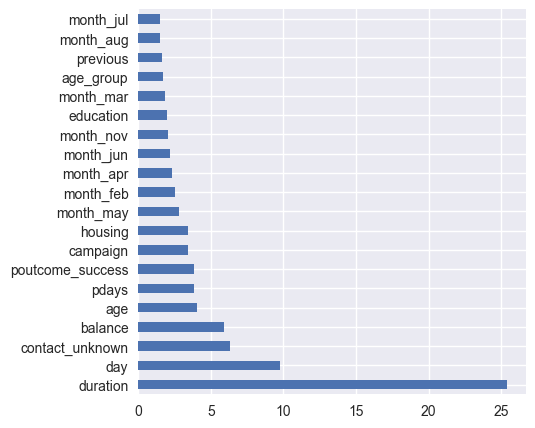

In [44]:
# Выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(cbc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh');

In [45]:
%%time
# Напишем функцию для оптимизации
def optuna_cbc(trial):
    """Функция, обучающая модель CatBoostClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространство поиска гиперпараметров
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 2, 9),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS', 'No']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8)
    }
    # Создаем модель
    model = CatBoostClassifier(
        **params,
        random_seed=42,
        iterations=200,
        verbose=False
    )
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score
# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_cbc = optuna.create_study(
    study_name="cbc_opt",
    direction="maximize",
    sampler=TPESampler(seed=123)
)
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_cbc.optimize(optuna_cbc, n_trials=50)
print("Наилучшие гиперпараметры {}".format(study_cbc.best_params))
print("f1_score на обучающем наборе: {:.4f}\n".format(study_cbc.best_value))

# Передаем модели коллекцию оптимальных гиперпараметров
cbc_opt = CatBoostClassifier(**study_cbc.best_params, random_state=42, verbose=False)
cbc_opt.fit(X_train_scaled, y_train)
y_pred_test_cbc_opt = cbc_opt.predict(X_test_scaled)
print(f'cbc_opt accuracy-score: {round(metrics.accuracy_score(y_test, y_pred_test_cbc_opt), 4)}')
print(f'cbc_opt f1-score: {round(metrics.f1_score(y_test, y_pred_test_cbc_opt), 4)}')
pred_proba_cbc_opt = cbc_opt.predict_proba(X_test_scaled)[:, 1]
roc_auc_cbc_opt = metrics.roc_auc_score(y_test, pred_proba_cbc_opt).round(4)
print("roc-auc на тестовой выборке:", roc_auc_cbc_opt)

Наилучшие гиперпараметры {'learning_rate': 0.0919006246984397, 'depth': 7, 'l2_leaf_reg': 7.1057910079302, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'max_ctr_complexity': 8}
f1_score на обучающем наборе: 0.8610

cbc_opt accuracy-score: 0.865
cbc_opt f1-score: 0.8608
roc-auc на тестовой выборке: 0.9315
CPU times: total: 1min 23s
Wall time: 4min 56s


Оптимизированный CatBoostClassifier не впечатляет: все метрики хуже, чем у исходной. Он даже несколько уступает базовой модели.

## Результаты и выводы

<a id='5'></a>
<a href ="#0">Вернуться к содержанию.</a>

Приведем результаты в виде таблицы.

|model|accuracy|$F_1$|roc auc|time|
|-|-|-|-|-|
|**bl_cbc**|0.8638|0.86|**0.9333**|17.1s|
|**log_reg**|0.8262|0.8125|0.9056|962ms|
|**dtc**|0.817|0.803|0.9056|**30.1ms**|
|**gc_dtc**|0.8229|0.8174|0.8757|13.9s|
|**rfc_opt**|0.8591|0.8571|0.9235|51.2s|
|**gbc_opt**|0.8585|0.8533|0.9284|3min 26s|
|**stack**|0.8573|0.8527|0.9294|10.6s|
|**cbc**|**0.8674**|**0.8638**|0.932|2.75s|
|**cbc_opt**|0.865|0.8608|0.9315|4min 56s|

Итак, лучшей моделью следует признать CatBoostClassifier на обработанных данных, т.к. две из трех метрик оказались лучше всего у нее. Лучшая метрика roc auc осталась за базовой моделью. А быстрее всех оказался алгоритм дерева решений - худший результат по двум из трех метик у него же.